Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter

#### DATA

FUNCTIONS

In [35]:
def gbm_simulator_with_deltas(S0, mu, sigma, n_days=12, n_sequences=50000, annual_trading_days=252):
    sequences = []
    delta_sequences = []
    
    for i in range(n_sequences):
        # Time horizon and time step
        T = n_days / annual_trading_days
        dt = T / n_days
        
        # Time vector
        t = np.linspace(0, T, n_days)
        
        # Generate Wiener process increments
        W_increments = np.random.normal(0, np.sqrt(dt), n_days)
        W = np.cumsum(W_increments)  # Cumulative Wiener process
        
        # Geometric Brownian Motion (GBM) process
        S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
        
        # Calculate price deltas (differences between consecutive prices)
        Delta_GBM = np.diff(S)  # Price deltas
        
        sequences.append(S)
        delta_sequences.append(Delta_GBM)
    
    return np.array(sequences), np.array(delta_sequences)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, seq_length = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)

    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    # Split the data based on 60/20/20 ratio
    train_size = int(0.6 * n_sequences)
    val_size = int(0.2 * n_sequences)
    
    train_data = tokenized_sequences[:train_size]  # First 60% of sequences for training
    val_data = tokenized_sequences[train_size:train_size + val_size]  # Next 20% for validation
    test_data = tokenized_sequences[train_size + val_size:]  # Remaining 20% for testing

    print('Number of Tokens:', num_bins)
    print('Training Data Shape:', train_data.shape)
    print('Validation Data Shape:', val_data.shape)
    print('Test Data Shape:', test_data.shape)

    return train_data, val_data, test_data, num_bins

def calculate_entropy(sequence):
    token_counts = Counter(sequence)
    total_tokens = len(sequence)
    # Probability distribution of tokens
    probabilities = {token: count / total_tokens for token, count in token_counts.items()}
    # Calculate the Shannon entropy
    entropy = -sum(p * np.log(p) for p in probabilities.values())
    return entropy



SETTINGS

In [36]:
S0 = 100                # Initial stock price
mu = 0.1                # Annual drift
sigma = 0.2             # Volatility
n_days = 12             # Sequence length (52 days)
n_sequences = 50000     # Number of sequences to simulate


Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$


In [37]:
Price_GBM, Delta_GBM = gbm_simulator_with_deltas(S0, mu, sigma, n_days=n_days, n_sequences=n_sequences)

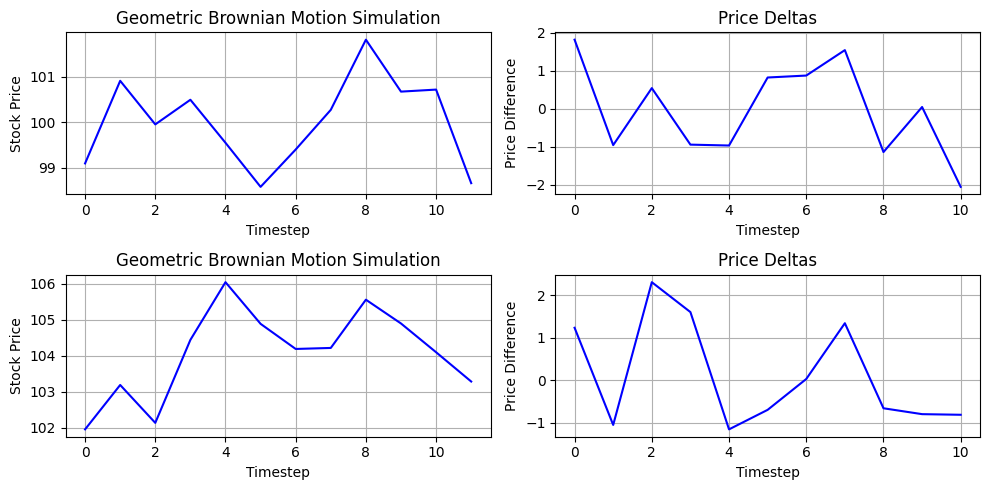

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs[0,0].plot(Price_GBM[0], color='blue')
axs[0,0].set_title('Geometric Brownian Motion Simulation')
axs[0,0].set_xlabel('Timestep')
axs[0,0].set_ylabel('Stock Price')
axs[0,0].grid('True')

axs[0,1].plot(Delta_GBM[0], color='blue')
axs[0,1].set_title('Price Deltas')
axs[0,1].set_xlabel('Timestep')
axs[0,1].set_ylabel('Price Difference')
axs[0,1].grid('True')

axs[1,0].plot(Price_GBM[5], color='blue')
axs[1,0].set_title('Geometric Brownian Motion Simulation')
axs[1,0].set_xlabel('Timestep')
axs[1,0].set_ylabel('Stock Price')
axs[1,0].grid('True')

axs[1,1].plot(Delta_GBM[5], color='blue')
axs[1,1].set_title('Price Deltas')
axs[1,1].set_xlabel('Timestep')
axs[1,1].set_ylabel('Price Difference')
axs[1,1].grid('True')
plt.tight_layout()
plt.show()

BIN WIDTH

In [39]:
bin_width = 0.3
print('Standard Deviation of Price Deltas:', np.round(np.std(Delta_GBM.flatten()),3))
print('BIN WIDTH: ', bin_width)

Standard Deviation of Price Deltas: 1.265
BIN WIDTH:  0.3


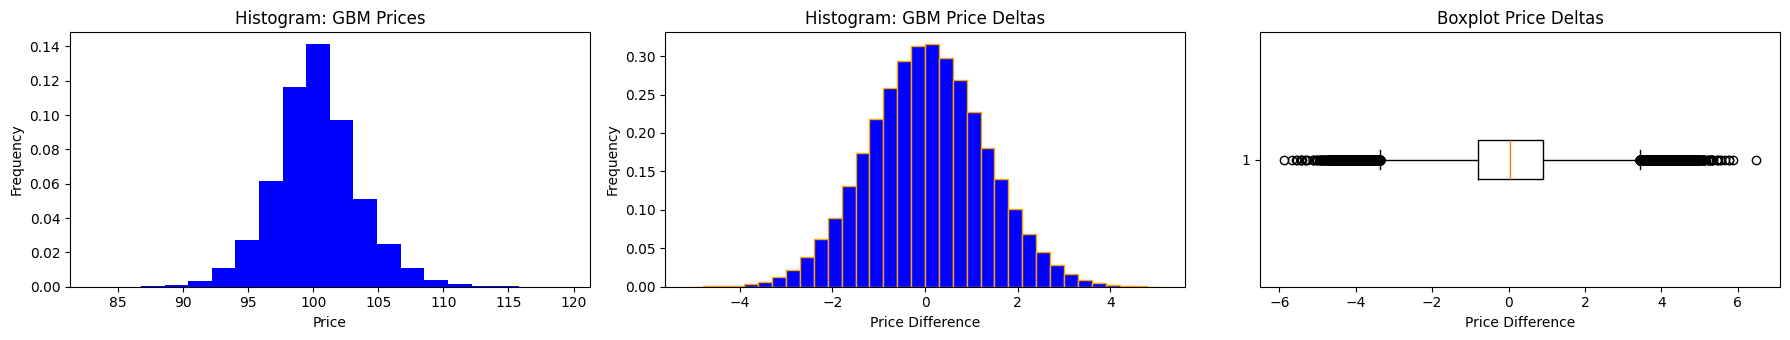

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM.flatten(), bins=20, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bins = np.arange(-5.1, 5.1 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM.flatten(), 
            bins=bins, 
            edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM.flatten(), vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


In [41]:
train_data, val_data, test_data, token_size = tokenize_deltas(Delta_GBM, bin_start=-5.1, bin_stop=5.1, bin_width=bin_width)

Number of Tokens: 34
Training Data Shape: (30000, 11)
Validation Data Shape: (10000, 11)
Test Data Shape: (10000, 11)


In [42]:
class MLPModel(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Fully connected hidden layers
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)     # First hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)        # Second hidden layer
        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)   # Output layer
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Embedding Layer: Shape (batch_size, sequence_length, embedding_dim)
        embedded = self.embedding(x)
        # Flatten: [batch_size * seq_len, embedding_dim]
        # Flatten the input: Combine sequence and embedding dimensions for MLP processing
        embedded = embedded.view(embedded.size(0) * embedded.size(1), -1) 
        # Fully connected layers
        out = self.relu(self.fc1(embedded))
        out = self.relu(self.fc2(out))
        # Output layer: [batch_size * seq_len, output_dim]
        logits = self.fc_out(out)
        # Reshape back to (batch_size, sequence_length, output_dim)
        logits = logits.view(x.size(0), x.size(1), -1)
        return logits

#### Train setting:

| Train set:                           |     30'000  Sequences        |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |             
| **Batch size:**                      | **512**                      |


In [57]:
vocab_size = token_size                         # Example vocab size (number of tokens)
embedding_dim = 32                              # Embedding size
hidden_dim = 128                                # Hidden Dimension
output_dim = vocab_size                         # Output Dimension
sequence_lengthseq_len = len(train_data[0])     # Length of your tokenized sequences

batch_size = 512                                # Batch Size
learning_rate = 0.001                           # Learning Rate
num_epochs = 10                                 # Number of epochs to train

In [58]:
model_supervised = MLPModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_data_supervised = torch.tensor(train_data, dtype=torch.long)

val_supervised_inputs = torch.tensor(val_data[:, :-1], dtype=torch.long)
val_supervised_targets = torch.tensor(val_data[:, 1:], dtype=torch.long)
val_supervised_targets = val_supervised_targets.reshape(-1)


train_losses = []
val_losses = []

best_val_loss = float('inf')

for epoch in range(num_epochs):

    temp_train_loss = []
    temp_val_loss = []
    
    ## ============
    ## TRAINING
    ## ============
    
    # Shuffle the data at the beginning of the epoch
    indices = np.arange(len(train_data_supervised))
    np.random.shuffle(indices)
    
    for batch_idx in range(0, len(train_data_supervised), batch_size):
        
        model_supervised.train()
        batch_indices = indices[batch_idx:batch_idx + batch_size]
        batch = train_data_supervised[batch_indices]

        inputs = batch[:, :-1]
        targets = batch[:, 1:]

        logits = model_supervised(inputs)
        logits = logits.view(-1, vocab_size)    # Flatten logits: (batch_size * seq_len, num_bins)
        targets = targets.reshape(-1)           # Flatten targets: (batch_size * seq_len)

        loss = criterion(logits, targets)
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the model parameters

        train_losses.append(loss.item())
        temp_train_loss.append(loss.item())

        ## ============
        ## VALIDATION
        ## ============

        model_supervised.eval()

        with torch.no_grad():

            logits = model_supervised(val_supervised_inputs)
            logits = logits.view(-1, vocab_size)
            loss = criterion(logits, val_supervised_targets)
            val_losses.append(loss.item())
            temp_val_loss.append(loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_train_loss):.4f} - Val Loss: {np.mean(temp_val_loss):.4f}")


Epoch 1/10 - Train Loss: 2.9910 - Val Loss: 2.9799
Epoch 2/10 - Train Loss: 2.8621 - Val Loss: 2.8621
Epoch 3/10 - Train Loss: 2.8615 - Val Loss: 2.8617
Epoch 4/10 - Train Loss: 2.8612 - Val Loss: 2.8614
Epoch 5/10 - Train Loss: 2.8613 - Val Loss: 2.8613
Epoch 6/10 - Train Loss: 2.8608 - Val Loss: 2.8612
Epoch 7/10 - Train Loss: 2.8611 - Val Loss: 2.8614
Epoch 8/10 - Train Loss: 2.8612 - Val Loss: 2.8616
Epoch 9/10 - Train Loss: 2.8611 - Val Loss: 2.8617
Epoch 10/10 - Train Loss: 2.8610 - Val Loss: 2.8616


Entropy of Validation Data: 2.859


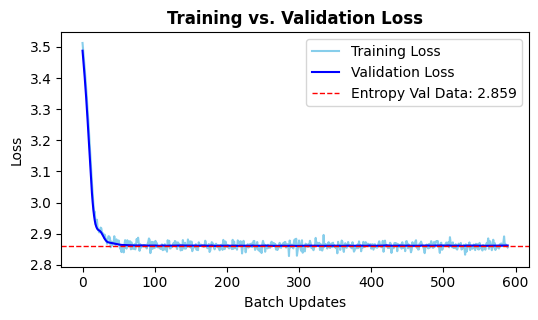

In [59]:
# Entropy calculation and display
entropy_val = round(calculate_entropy(val_data.flatten()), 3)
print('Entropy of Validation Data:', entropy_val)

# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_losses, label='Training Loss', color='skyblue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='blue', linewidth=1.5)
plt.axhline(entropy_val, color='red', linestyle='--', linewidth=1, label=f'Entropy Val Data: {entropy_val}')
plt.title('Training vs. Validation Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()